## How to create a BNN for a simple regression task.

### Tutorial 4: Bayesian Neural network 

to support our learning in Lecture 10. Bayesian neural network in EE2102575

by *Suwichaya Suwanwimolkul, Ph.D.*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbySuwichaya/Statistical-Learning-EE575/blob/master/Tutorial4/main.ipynb)

In this tutorial, we will build two neural networks: (1) static NN and (2) BNN 

Each network has 2 linear layers with 1 activating function (sigmoid).
We set the same learning rate and number of epoches to compare which model is better... 

You can skip to each of the following topics...
- [Install package](#installing-package)
- [Import data](#import-data)
- [Static neural network](#static-neural-network)
- [Bayesian neural network](#bayesian-neural-network)   
    - [Gaussian object](#gaussian-object)
    - [Gaussian mixture for weight priors](#gaussian-mixture-for-weight-prior)
    - [Bayesian Linear Layer](#bayesian-linear-layer)
    - [Bayesian Linear Model](#bayesian-linear-model)
    - [Training BNN](#training-bnn)
- [Learning performance](#learning-performance)
- [Testing performance](#testing-performance)

Our implementation is based on [Nitarshan's Bayes-by-backprop](https://github.com/nitarshan/bayes-by-backprop) and 'Weight Uncertainty Neural Network' JMRL 2018.


**Here** is a fews things for you to know when developing BNN. 

- BNN can be extended from NN module of Pytorch. 
  
- The difference is the sampling process.  

  <img src="figures/sampling.gif" alt="Sampling" width="200"/>

- Don't forget that for BNN, you will need to sample the weights. 

  Therefore, you can use these layers to perform the same task and extended it for BNN.   

  <img src="figures/Fig1.png" alt="BNN Weights" width="400"/>  

- Don't forget then when training BNN, the proceedure will be different:    

  <img src="figures/Fig2.png" alt="BNN Training" width="600"/>   


## Installing package

In [1]:
#! pip3 install torch torchvision torchaudio

## Import data

We will learn about this example through the car-price dataset. 
Just import the dataset from the MS team! 

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn 
import math

import zipfile
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  

from sklearn.model_selection import train_test_split

In [3]:
class CustomDataset(Dataset):
    def __init__(self, X_train_, y_train_, X_test_=None, y_test_=None, mode="Train"):
        self.training_data  = X_train_
        self.training_label = y_train_
        
        if mode == "Train":
            self.data  = X_train_
            self.label = y_train_
            self.length = X_train_.shape[0]

        elif  mode == "Test" or mode == "Valid":
            assert X_test_ is not None
            assert y_test_ is not None

            self.data   = X_test_
            self.label  = y_test_
            self.length = X_test_.shape[0]
 

        self.XScaler    = StandardScaler()
        self.training_data = self.XScaler.fit_transform(self.training_data).astype("float32")
        self.data          = self.XScaler.transform(self.data).astype("float32") 

        self.YScaler = StandardScaler()
        self.training_label = self.YScaler.fit_transform(self.training_label).astype("float32") 
        self.label          = self.YScaler.transform(self.label).astype("float32")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        sample = self.data[idx, :] 
        label  = self.label[idx] 
        return sample, label

In [ ]:
foldername = "vehicle-dataset"

with zipfile.ZipFile("vehicle-dataset-from-cardekho.zip","r") as zip_ref:
    zip_ref.extractall(foldername)

df = pd.read_csv('%s/car data.csv' % foldername)

df[['Car_Name', 'Fuel_Type','Seller_Type','Transmission']] = df.loc[:,['Car_Name', 'Fuel_Type','Seller_Type','Transmission']].apply(LabelEncoder().fit_transform)
print("After Encoding: ")
print(np.unique(df['Car_Name'].values))
print(np.unique(df['Transmission'].values))
print(np.unique(df['Fuel_Type'].values))
print(np.unique(df['Seller_Type'].values))

Feat_List = ['Car_Name', 'Year', 'Present_Price', 'Kms_Driven', 'Fuel_Type','Seller_Type','Transmission', 'Owner']
dfX = df.loc[:, Feat_List].values
dfy = df['Selling_Price'].values.reshape(-1,1)

X_train_, X_test_, y_train_, y_test_ = train_test_split(dfX, dfy, test_size=0.2, random_state= 0)
X_train_, X_val_, y_train_, y_val_   = train_test_split(X_train_, y_train_, test_size=0.2, random_state=0)


TrainingData = CustomDataset(X_train_, y_train_, mode="Train")
ValidateData = CustomDataset(X_train_, y_train_, X_val_,  y_val_,  mode="Valid")
TestingData  = CustomDataset(X_train_, y_train_, X_test_, y_test_, mode="Test")

##### You can use the following cell to explore your training data. 

In [5]:
from tqdm import tqdm
testing_dataloader = DataLoader(TestingData, batch_size=1, shuffle=False)

pbar  = tqdm(testing_dataloader)

for i, data in enumerate(pbar): 
    
    data_x, data_y = data  
    
    pbar.set_description("[%d] ...my message " % (i))


[60] ...my message : 100%|██████████| 61/61 [00:00<00:00, 5413.38it/s]


# Static Neural Network

This example we define 2 linear layers for an NN where MSE loss is used in training the model for regression task. 

In [6]:
class LinearModel(nn.Module):
    def __init__(self, in_features=4, out_features=1):
        super().__init__() 
        # Weight parameters
        self.fc1 = nn.Linear(in_features,16)  
        self.fc2 = nn.Linear(16, out_features)   
        self.fc3 = nn.Sigmoid()
        self.loss = nn.MSELoss() 

    def forward(self, x): 
        x = self.fc1(x)
        x = self.fc2(x) 
        x = self.fc3(x)
        return x
    
    def mseloss(self, y_predict, y_gt):
        loss = self.loss(y_predict, y_gt)   
        return loss  

In [7]:
## Initialize the model and set the optimizer for training. 

import torch.optim as optim

in_features  = 8
out_features = 1

## Initialize the model
myLinModel = LinearModel(in_features=in_features, out_features=out_features)

## Set the optimizer for training.
optimizer  = optim.Adam(myLinModel.parameters(), lr=0.01)

Training Linear Model with validation

In [8]:
my_NN_training_loss = []
my_NN_validating_loss = []
my_NN_MSE_inv_error = []
num_epoch = 20 

for ep in range(num_epoch): 


    av_valid_loss = 0
    av_mse_valid_loss = 0
    av_training_loss = 0 

    training_dataloader = DataLoader(TrainingData, batch_size=16, shuffle=True)
    pbar  = tqdm(training_dataloader)

    # Setting model for training
    myLinModel = myLinModel.train()
    for i, (X, y_gt) in enumerate(pbar):  

        y_pred         = myLinModel(X) 
        loss           = myLinModel.mseloss(y_pred, y_gt)

        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters
        av_training_loss += loss.item()

        pbar.set_description("[EP%d][%d] TRAIN Av. Loss = %0.2f" % (ep, i, loss.item()))


    my_NN_training_loss.append(av_training_loss/(16*(i+1)))  
    # Setting model for validating 
    valid_dataloader = DataLoader(ValidateData, batch_size=1, shuffle=True)
    pbar  = tqdm(valid_dataloader)
    myLinModel.eval()
    for i, (X, y_gt) in enumerate(pbar):  

        with torch.no_grad():
            y_pred         = myLinModel(X)  

        y_pred_inverse = ValidateData.YScaler.inverse_transform(y_pred)
        y_gt_inverse   = ValidateData.YScaler.inverse_transform(y_gt)

        valid_loss      = myLinModel.mseloss(y_pred, y_gt)
        mse_inv_error   = myLinModel.mseloss(torch.tensor(y_pred_inverse), torch.tensor(y_gt_inverse))
 
        av_valid_loss += valid_loss.item()
        av_mse_valid_loss +=mse_inv_error.item()  
 

        pbar.set_description("-----[%d] VALID Av. Loss = %0.2f" % ( i, mse_inv_error.item()))    

    print("Training ERROR %0.2f Valid ERROR: %0.2f" %(av_training_loss/(16*(i+1)), av_mse_valid_loss/(i+1)))
    my_NN_validating_loss.append(av_valid_loss/((i+1)))
    my_NN_MSE_inv_error.append(av_mse_valid_loss/(i+1))

-----[47] VALID Av. Loss = 18.39: 100%|██████████| 48/48 [00:00<00:00, 2982.00it/s]


Training ERROR 0.02 Valid ERROR: 26.17


-----[47] VALID Av. Loss = 22.35: 100%|██████████| 48/48 [00:00<00:00, 3018.84it/s]


Training ERROR 0.01 Valid ERROR: 19.75


-----[47] VALID Av. Loss = 20.18: 100%|██████████| 48/48 [00:00<00:00, 2665.84it/s]


Training ERROR 0.01 Valid ERROR: 18.20


-----[47] VALID Av. Loss = 26.09: 100%|██████████| 48/48 [00:00<00:00, 3130.03it/s]


Training ERROR 0.01 Valid ERROR: 17.93


-----[47] VALID Av. Loss = 14.43: 100%|██████████| 48/48 [00:00<00:00, 2360.88it/s]


Training ERROR 0.01 Valid ERROR: 17.99


-----[47] VALID Av. Loss = 15.77: 100%|██████████| 48/48 [00:00<00:00, 1925.65it/s]


Training ERROR 0.01 Valid ERROR: 18.04


-----[47] VALID Av. Loss = 178.31: 100%|██████████| 48/48 [00:00<00:00, 2084.08it/s]


Training ERROR 0.01 Valid ERROR: 17.42


-----[47] VALID Av. Loss = 0.22: 100%|██████████| 48/48 [00:00<00:00, 2510.90it/s]


Training ERROR 0.01 Valid ERROR: 17.02


-----[47] VALID Av. Loss = 16.50: 100%|██████████| 48/48 [00:00<00:00, 2407.95it/s]


Training ERROR 0.01 Valid ERROR: 17.00


-----[47] VALID Av. Loss = 23.98: 100%|██████████| 48/48 [00:00<00:00, 1708.18it/s]


Training ERROR 0.01 Valid ERROR: 17.15


-----[47] VALID Av. Loss = 0.16: 100%|██████████| 48/48 [00:00<00:00, 2376.83it/s]


Training ERROR 0.01 Valid ERROR: 18.10


-----[47] VALID Av. Loss = 6.87: 100%|██████████| 48/48 [00:00<00:00, 1926.87it/s]


Training ERROR 0.01 Valid ERROR: 19.11


-----[47] VALID Av. Loss = 3.32: 100%|██████████| 48/48 [00:00<00:00, 2463.37it/s]


Training ERROR 0.01 Valid ERROR: 19.03


-----[47] VALID Av. Loss = 16.58: 100%|██████████| 48/48 [00:00<00:00, 2300.27it/s]


Training ERROR 0.01 Valid ERROR: 18.86


-----[47] VALID Av. Loss = 3.69: 100%|██████████| 48/48 [00:00<00:00, 2885.62it/s]


Training ERROR 0.01 Valid ERROR: 18.72


-----[47] VALID Av. Loss = 40.05: 100%|██████████| 48/48 [00:00<00:00, 2919.81it/s]


Training ERROR 0.01 Valid ERROR: 18.80


-----[47] VALID Av. Loss = 16.99: 100%|██████████| 48/48 [00:00<00:00, 2193.67it/s]


Training ERROR 0.01 Valid ERROR: 18.80


-----[47] VALID Av. Loss = 4.09: 100%|██████████| 48/48 [00:00<00:00, 2859.87it/s]


Training ERROR 0.01 Valid ERROR: 18.81


-----[47] VALID Av. Loss = 5.74: 100%|██████████| 48/48 [00:00<00:00, 3104.16it/s]


Training ERROR 0.01 Valid ERROR: 18.81


-----[47] VALID Av. Loss = 16.74: 100%|██████████| 48/48 [00:00<00:00, 1856.95it/s]

Training ERROR 0.01 Valid ERROR: 18.81


# Bayesian Neural Network

- Let's assume that the weights and biases are sampled from Gaussian distribution. 

- We assume that the prior of the weights are from Gaussian mixture (following the paper 'Weight Uncertainty Neural Network' JMRL 2018)

- Then, the configuration for BNN follows:

    - Customize a new layer, called `BayesianLinearLayer`

    - Putting the new layers in `BayesianLinearModel` which is built on `torch.nn.module`

    - The main difference to standard NN is the additional part of `sampling` and `log-probability` calculation.

### Gaussian object

To generate the Gaussian samples for weights and biases. 

In [9]:
import torch.nn.functional as F
import math

class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size())
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi)) - torch.log(self.sigma) - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

### Gaussian Mixture for weight prior

To generate the probability for the weights prior as a Gaussian mixture following 'Weight Uncertainty Neural Network' JMRL 2015.

In [10]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

### Bayesian Linear Layer

For each Bayesian linear layer, the weight and bias are sampled from a pre-defined probability distribution (Gaussian)

- The mean and variance for weights are contained in `self.weight_mu` and `self.weight_rho`

- The mean and variance for bias are contained in `self.bias_mu` and `self.bias_rho`

- The prior probability of weigths and bias are defined by 
    
    ```
        self.weight_prior = ScaleMixtureGaussian(pi, sigma1, sigma2)
        self.bias_prior   = ScaleMixtureGaussian(pi, sigma1, sigma2)
    ```

- Note that if we run `BayesianLinearLayer` with `sample=False`, 
    then the foward function will return the sample mean of self.weight and bias


In [11]:
class BayesianLinearLayer(nn.Module):
    def __init__(self, pi, sigma1, sigma2, in_features=16, out_features=16):
        super().__init__() 
        self.in_features = in_features
        self.out_features = out_features

        # Weight parameters
        self.weight_mu  = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight     = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu  = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias     = Gaussian(self.bias_mu, self.bias_rho) 

        self.log_prior = 0
        self.log_variational_posterior = 0

        # Define prior for parameters 
        self.weight_prior = ScaleMixtureGaussian(pi, sigma1, sigma2)
        self.bias_prior   = ScaleMixtureGaussian(pi, sigma1, sigma2)

    def forward(self, input, sample=False):
        
        if sample == True: 
            weight = self.weight.sample()
            bias = self.bias.sample()

            self.log_prior_W             = self.weight_prior.log_prob(weight)  +  self.bias_prior.log_prob(bias)  
            self.log_q_posterior         = self.weight.log_prob(weight)        +  self.bias.log_prob(bias) 

        else:
            weight = self.weight.mu
            bias = self.bias.mu

        return F.linear(input, weight, bias) 
     

### Bayesian Linear Model

The init and forward functions are similar to the static NN. 
Except that we added the following parts to facilitate the calculation of the training loss in the Bayes-by-backprop Algorithm in Lecture 10. 


- `log_prior` to calculate the log of probability of the weights prior

- `log_q_posterior` to calculate the log of the proposal probability of the weights given the updated hyper-parameters.

- `ELBO_loss` to calculate the training loss in the Bayes-by-backprop Algorithm for each $i$th Monte Carlo sample as follows:


    $$ ELBO(i) =  \log{(q^i \vert w^i)} - \log{(D \vert w^i)} + \log{(w^i)}$$

    where each of these terms correspond to the following variables:

    - $\log{(q^i \vert w^i)}$ : `self.log_q_posterior`

    - $\log{(D \vert w^i)}$   : `negative_log_likelihood` (you can use the Gaussian Distribution for the likelihood, or `F.nll_loss(outputs.mean(0), target, size_average=False)`)
    
    - $\log{(w^i)}$           : `self.log_prior()`

 

In [12]:
import torch
import torch.nn as nn 
import math

class BayesianLinearModel(nn.Module):
    def __init__(self, in_features=4, out_features=1): 
        super().__init__()
        pi = 0.5
        sigma1 = torch.Tensor([math.exp(-0)])
        sigma2 = torch.Tensor([math.exp(-1)])

        self.fc1 = BayesianLinearLayer(pi, sigma1, sigma2, in_features=in_features, out_features=16)   # nn.Linear(in_features,16)
        self.fc2 = BayesianLinearLayer(pi, sigma1, sigma2, in_features=16, out_features=out_features)  # nn.Linear(16, out_features)
        self.fc3 = nn.Sigmoid() 

    def forward(self, x, sample=False):
        x = self.fc1(x, sample=sample)
        x = self.fc2(x, sample=sample)
        y = self.fc3(x) 
        return y
    
    def log_prior(self):
        return self.fc1.log_prior_W + self.fc2.log_prior_W  
    
    def log_q_posterior(self):
        return self.fc1.log_q_posterior + self.fc2.log_q_posterior

    def neglog_prob(self, y_pred, y_target):
        sigma = torch.norm(y_pred - y_target,p=2)
        return -(-math.log(math.sqrt(2 * math.pi)) - torch.log(sigma) - ((y_pred - y_target) ** 2) / (2 * sigma**2)).sum()  
    
    def ELBO_loss(self,  input, target, num_samples=1): 
        b, cl = target.shape

        outputs                    = torch.zeros(num_samples, b, cl)
        log_priors                 = torch.zeros(num_samples)
        log_q_posterior            = torch.zeros(num_samples)

        for i in range(num_samples):
            outputs[i]                    = self(input, sample=True) # Call 'forward(self, x, sample=False)'
            log_priors[i]                 = self.log_prior()
            log_q_posterior[i]            = self.log_q_posterior()
        
        log_prior                          = log_priors.mean()
        log_q_posterior                    = log_q_posterior.mean()
        average_output                     = outputs #.mean(dim=0)  
        negative_log_likelihood            = self.neglog_prob(average_output, target)/num_samples
        loss                               = negative_log_likelihood -  (log_q_posterior + log_prior)/b 
        return loss


## Training BNN

Back-by-propagation follows the steps in this figure:

  <img src="figures/Fig2.png" alt="BNN Training" width="600"/>   

In [13]:
import torch.optim as optim

in_features  = 8
out_features = 1

## Initialize the model
myBayesModel = BayesianLinearModel(in_features=in_features, out_features=out_features)

## Set the optimizer for training.
optimizer  = optim.Adam(myBayesModel.parameters(), lr=0.01)

In [14]:
my_BNN_training_loss = []
my_BNN_validating_loss = []
my_BNN_MSE_inv_error = []

num_epoch = 20 

num_train_samples = 100
num_test_samples = 100
MSEloss = nn.MSELoss() 

for ep in range(num_epoch): 


    av_training_loss = 0
    av_validating_loss = 0
    av_mse_inv_error = 0


    training_dataloader = DataLoader(TrainingData, batch_size=16, shuffle=True)
    pbar  = tqdm(training_dataloader)

    # Setting model for training
    myBNN_Model = myBayesModel.train()
    for i, (X, y_gt) in enumerate(pbar):  
        
        myBNN_Model.zero_grad() 
        loss           = myBNN_Model.ELBO_loss(X, y_gt, num_samples=num_train_samples)

        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters
        av_training_loss += loss.item()  

        pbar.set_description("[EP%d][%d] TRAIN Av. Loss = %0.2f" % (ep, i, loss.item() ))

    my_BNN_training_loss.append(av_training_loss/(16*(i+1)))

    # Setting model for validating 
    valid_dataloader = DataLoader(ValidateData, batch_size=1, shuffle=True)
    pbar  = tqdm(valid_dataloader)
    
    myBNN_Model.eval()
    correct = 0
    corrects = np.zeros(num_test_samples+1, dtype=int)

    for i, (X, y_gt) in enumerate(pbar):  

        b, cl = y_gt.shape 
        outputs        = torch.zeros(num_test_samples+1, b)
    
        with torch.no_grad():
            for i in range(num_test_samples):
                outputs[i,:]         = myBNN_Model(X, sample=True) 

            outputs[num_test_samples, :] = myBNN_Model(X, sample=False) 

        y_pred = outputs.mean().view(1,-1) 
 
        y_pred_inverse = ValidateData.YScaler.inverse_transform(y_pred)
        y_gt_inverse   = ValidateData.YScaler.inverse_transform(y_gt)

        valid_loss      = MSEloss(y_pred, y_gt)
        mse_inv_error   = MSEloss(torch.tensor(y_pred_inverse), torch.tensor(y_gt_inverse))

        av_validating_loss += valid_loss.item() 
        av_mse_inv_error += mse_inv_error.item() 
        pbar.set_description("-----[%d] VALID Av. Loss = %0.2f" % ( i, valid_loss.item()))  

    print("Training ERROR %0.2f Valid ERROR: %0.2f" %(av_training_loss/(16*(i+1)), av_mse_inv_error/(i+1)))

    my_BNN_validating_loss.append(av_validating_loss/(i+1))
    my_BNN_MSE_inv_error.append(av_mse_inv_error/(i+1))

-----[99] VALID Av. Loss = 1.28: 100%|██████████| 48/48 [00:01<00:00, 30.42it/s]


Training ERROR 0.34 Valid ERROR: 12.02


-----[99] VALID Av. Loss = 0.39: 100%|██████████| 48/48 [00:01<00:00, 29.97it/s]


Training ERROR 0.31 Valid ERROR: 9.38


-----[99] VALID Av. Loss = 0.37: 100%|██████████| 48/48 [00:01<00:00, 30.35it/s]


Training ERROR 0.30 Valid ERROR: 8.37


-----[99] VALID Av. Loss = 0.17: 100%|██████████| 48/48 [00:01<00:00, 30.06it/s]


Training ERROR 0.28 Valid ERROR: 7.76


-----[99] VALID Av. Loss = 0.67: 100%|██████████| 48/48 [00:01<00:00, 30.01it/s]


Training ERROR 0.27 Valid ERROR: 7.48


-----[99] VALID Av. Loss = 0.16: 100%|██████████| 48/48 [00:01<00:00, 30.94it/s]


Training ERROR 0.26 Valid ERROR: 7.45


-----[99] VALID Av. Loss = 4.82: 100%|██████████| 48/48 [00:01<00:00, 29.87it/s]


Training ERROR 0.25 Valid ERROR: 7.45


-----[99] VALID Av. Loss = 0.04: 100%|██████████| 48/48 [00:01<00:00, 30.32it/s]


Training ERROR 0.24 Valid ERROR: 7.42


-----[99] VALID Av. Loss = 0.70: 100%|██████████| 48/48 [00:01<00:00, 30.29it/s]


Training ERROR 0.23 Valid ERROR: 7.43


-----[99] VALID Av. Loss = 0.66: 100%|██████████| 48/48 [00:01<00:00, 30.60it/s]


Training ERROR 0.22 Valid ERROR: 7.44


-----[99] VALID Av. Loss = 0.02: 100%|██████████| 48/48 [00:01<00:00, 30.39it/s]


Training ERROR 0.21 Valid ERROR: 7.48


-----[99] VALID Av. Loss = 0.40: 100%|██████████| 48/48 [00:01<00:00, 30.43it/s]


Training ERROR 0.20 Valid ERROR: 7.42


-----[99] VALID Av. Loss = 0.15: 100%|██████████| 48/48 [00:01<00:00, 31.20it/s]


Training ERROR 0.20 Valid ERROR: 7.52


-----[99] VALID Av. Loss = 0.69: 100%|██████████| 48/48 [00:01<00:00, 30.26it/s]


Training ERROR 0.19 Valid ERROR: 7.43


-----[99] VALID Av. Loss = 0.64: 100%|██████████| 48/48 [00:01<00:00, 29.22it/s]


Training ERROR 0.17 Valid ERROR: 7.39


-----[99] VALID Av. Loss = 0.06: 100%|██████████| 48/48 [00:01<00:00, 29.90it/s]


Training ERROR 0.16 Valid ERROR: 7.33


-----[99] VALID Av. Loss = 0.16: 100%|██████████| 48/48 [00:01<00:00, 29.84it/s]


Training ERROR 0.16 Valid ERROR: 7.34


-----[99] VALID Av. Loss = 0.70: 100%|██████████| 48/48 [00:01<00:00, 30.18it/s]


Training ERROR 0.15 Valid ERROR: 7.51


-----[99] VALID Av. Loss = 0.17: 100%|██████████| 48/48 [00:01<00:00, 30.79it/s]


Training ERROR 0.14 Valid ERROR: 7.39


-----[99] VALID Av. Loss = 0.64: 100%|██████████| 48/48 [00:01<00:00, 29.84it/s]

Training ERROR 0.13 Valid ERROR: 7.36


## Learning Performance

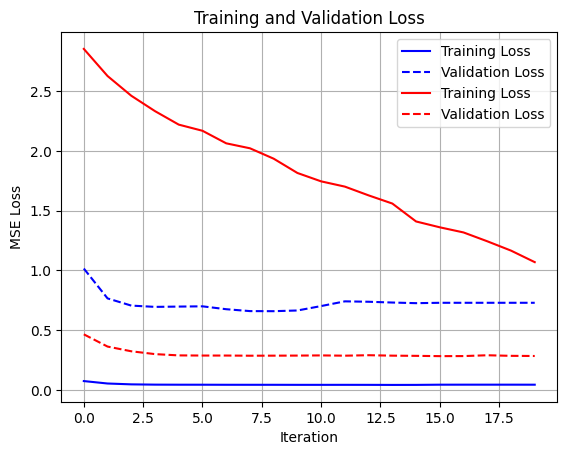

In [17]:
plt.plot(np.arange(len(my_NN_training_loss)), my_NN_training_loss, 'b-', label='Training NN')
plt.plot(np.arange(len(my_NN_validating_loss)),my_NN_validating_loss, 'b--', label='Validation NN')
plt.plot(np.arange(len(my_BNN_training_loss)), my_BNN_training_loss, 'r-', label='Training BNN')
plt.plot(np.arange(len(my_BNN_validating_loss)),my_BNN_validating_loss, 'r--', label='Validation BNN')
plt.title('Training and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

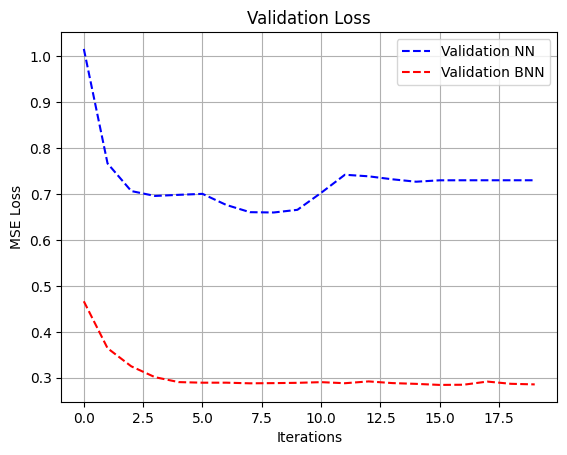

In [20]:
plt.plot(np.arange(len(my_NN_validating_loss)),my_NN_validating_loss, 'b--', label='Validation NN') 
plt.plot(np.arange(len(my_BNN_validating_loss)),my_BNN_validating_loss, 'r--', label='Validation BNN')
plt.title('Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

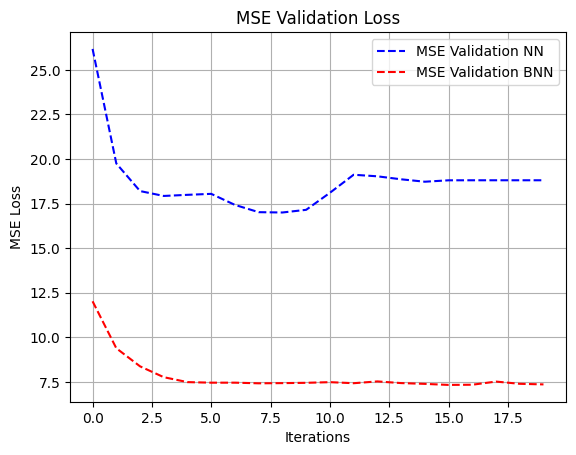

In [21]:
plt.plot(np.arange(len(my_NN_MSE_inv_error)),my_NN_MSE_inv_error, 'b--', label='MSE Validation NN') 
plt.plot(np.arange(len(my_BNN_MSE_inv_error)),my_BNN_MSE_inv_error, 'r--', label='MSE Validation BNN')
plt.title('MSE Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

## Testing Performance

In [23]:
testing_dataloader = DataLoader(TestingData, batch_size=1, shuffle=False)

  0%|          | 0/61 [00:00<?, ?it/s]

In [29]:
myLinModel.eval()
av_valid_loss = 0
av_mse_valid_loss = 0
pbar  = tqdm(testing_dataloader)
for i, (X, y_gt) in enumerate(pbar):  

    with torch.no_grad():
        y_pred         = myLinModel(X)  

    y_pred_inverse = ValidateData.YScaler.inverse_transform(y_pred)
    y_gt_inverse   = ValidateData.YScaler.inverse_transform(y_gt)

    valid_loss      = myLinModel.mseloss(y_pred, y_gt)
    mse_inv_error   = myLinModel.mseloss(torch.tensor(y_pred_inverse), torch.tensor(y_gt_inverse))

    av_valid_loss += valid_loss.item()
    av_mse_valid_loss +=mse_inv_error.item()  


    pbar.set_description("-----[%d] Static NN Testing Av. Loss = %0.2f" % ( i, av_mse_valid_loss/(i+1)))     

-----[60] Static NN Testing Av. Loss = 14.74: 100%|██████████| 61/61 [00:00<00:00, 2876.17it/s]


In [30]:
av_validating_loss = 0
av_mse_inv_error   = 0

myBNN_Model.eval() 
pbar  = tqdm(testing_dataloader) 
for i, (X, y_gt) in enumerate(pbar):  

    b, cl = y_gt.shape 
    outputs        = torch.zeros(num_test_samples+1, b)

    with torch.no_grad():
        for i in range(num_test_samples):
            outputs[i,:]         = myBNN_Model(X, sample=True) 

        outputs[num_test_samples, :] = myBNN_Model(X, sample=False) 

    y_pred = outputs.mean().view(1,-1) 

    y_pred_inverse = ValidateData.YScaler.inverse_transform(y_pred)
    y_gt_inverse   = ValidateData.YScaler.inverse_transform(y_gt)

    valid_loss      = MSEloss(y_pred, y_gt)
    mse_inv_error   = MSEloss(torch.tensor(y_pred_inverse), torch.tensor(y_gt_inverse))

    av_validating_loss += valid_loss.item() 
    av_mse_inv_error += mse_inv_error.item() 
    
    pbar.set_description("-----[%d] BNN Testing Av. Loss = %0.2f" % ( i, av_mse_inv_error/(i+1)))  

 

-----[99] BNN Testing Av. Loss = 8.27: 100%|██████████| 61/61 [00:02<00:00, 30.27it/s]
